In [50]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener

import math
import scipy

from kalman_filtering4 import oneIterPowerKalmanFilter


In [51]:
data_file = 'val_err_wo_lr_decay.json'
# data_file = 'val_err.json'
# data_file = 'bs_32_val_err.json'
with open(data_file) as f:
    val_acc = json.load(f)

val_err = 1 - np.array(val_acc)
num_epochs_between_eval = 20
min_delta = 5e-4
patience = 12
# steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

smooth_win_size = 55
whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)

In [52]:
minEpoch = (np.argmin(whole_smoothed_val_err)+1)*20
print(minEpoch, np.min(whole_smoothed_val_err), len(whole_smoothed_val_err))
earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
print(earlyStoppingStep, whole_smoothed_val_err[earlyStoppingStep//20+1])

9220 0.32954545454545453 505
9380 0.33674545613202184


<IPython.core.display.Javascript object>


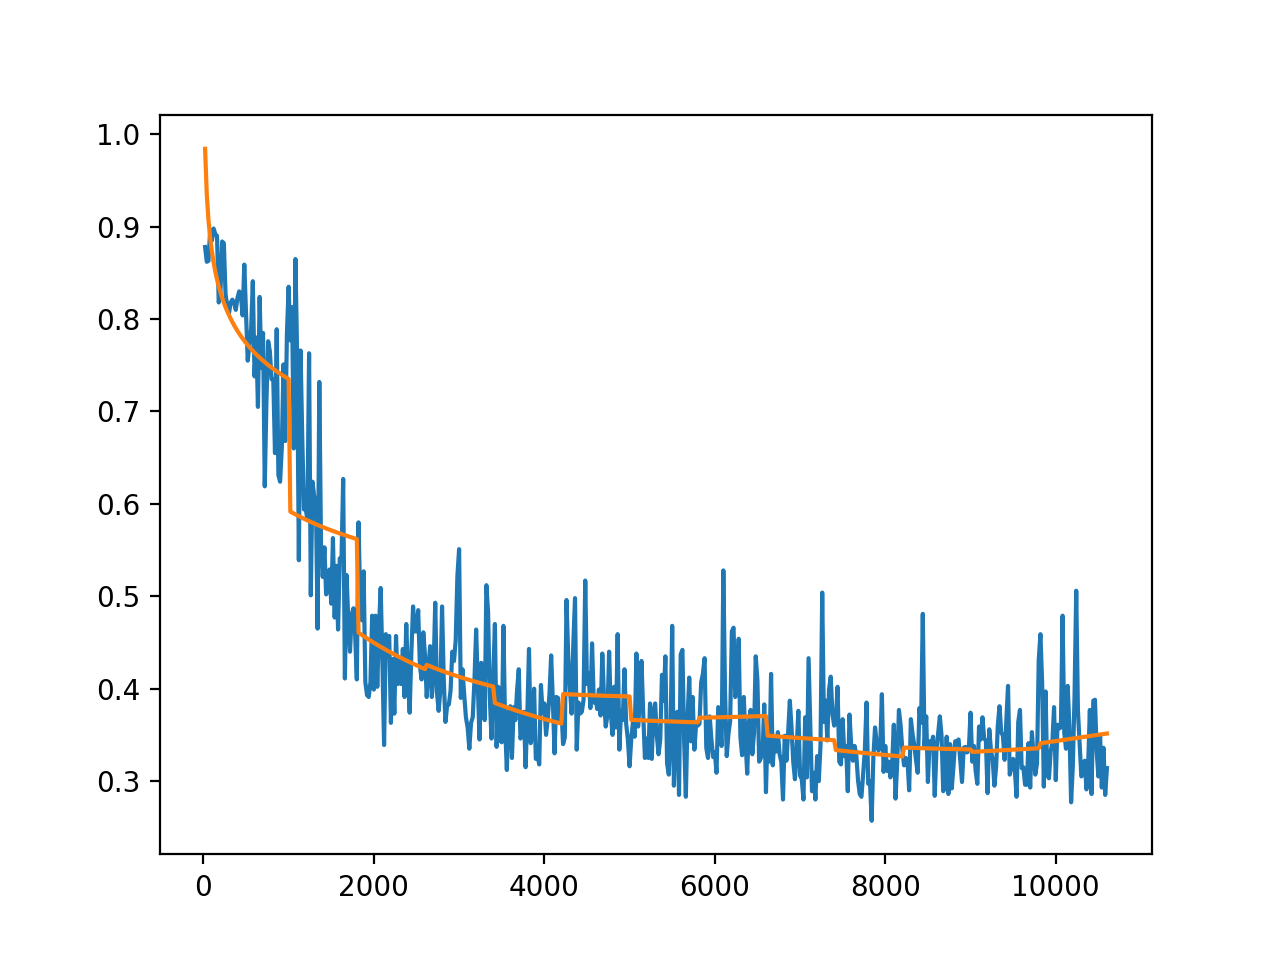

In [53]:
num_outliers = 0 # delete some outliers
smoothed_val_err = whole_smoothed_val_err[num_outliers:]

start_point = 50
pred_win_size = 100
left_tail_size = 0
period = 40
pred_min_delta = min_delta
wtype = 'linear'
num_samples = 1000

var_ud = 0
init_d = 0

input_data = []
for i, d in enumerate(val_err):
    if i >= pred_win_size:
        input_data.pop(0) 
    input_data.append(d)
    
    if i == start_point-1:
        KF = oneIterPowerKalmanFilter(num_epochs_between_eval,
                                 pred_win_size,
                                 period,
                                 input_data,
                                init_d,
                                  var_ud
                             )
    
    if i >= start_point and (i-start_point+1)%period == 0:
#         print(len(input_data))
        KF.oneIterKF(np.array(input_data))
#         print(KF.M_est)
#     signals = np.concatenate([signals, KF.sq_est])

# print(KF.all_estimates)

plt.figure()
KF_steps = (np.arange(len(KF.all_estimates)) + 1 + num_outliers)*num_epochs_between_eval
plt.plot(KF_steps, KF.all_original_data)
plt.plot(KF_steps, KF.all_estimates)
    
    
    

In [54]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def indicatorSimulation(data, 
                        smooth_win_size,
                         num_epochs_between_eval, 
                         min_delta, patience, 
                        report_period,
                         pred_win_size, 
                         period,
                        init_d,
                        var_ud = 1e-3,
                         start_point=100,                         
                        num_samples=1000,
                        upper_limit=2e4):
    upper_lim_points = upper_limit // num_epochs_between_eval
    
    def _addingNoiseBootstrapping(predicts, R, shift):
#         print(R)
        period = R.shape[0]
        noise_sample_size = len(predicts) // period
        residual = len(predicts) % period
#         print(residual)
        truncated_R = R[:residual,:residual]

        stopping_epochs = []
        for i in range(num_samples):
            noise = np.random.multivariate_normal(np.zeros(period), R, noise_sample_size).reshape((1,-1))[0]
            noise = np.concatenate([noise, np.random.multivariate_normal(np.zeros(residual), truncated_R)])
            measurement = predicts + noise
            smoothed_measurement = smooth_by_linear_filter(measurement, smooth_win_size)
            try:
                stopping_epochs.append(
                    early_stopping_step(measurement, min_delta, patience, smooth_win_size, num_epochs_between_eval) + shift)
#                 stopping_epochs.append(
#                     early_stopping_step(predicts, min_delta, patience, 1, num_epochs_between_eval) + shift)
            except:
                continue
        return np.mean(stopping_epochs), np.array(stopping_epochs), measurement, smoothed_measurement
    
    epoch_preds = []
    samples = []
    CIs = []
    
    KF_input_queue = []
    d_ests = []
    init_x = []
    KF = None
    for i, d in enumerate(data):
        global_step = (i+1)*num_epochs_between_eval
        ###############################
        # save time, should be deleted in practice
        if global_step > earlyStoppingStep:
            break
        ###############################
        
        if i < start_point:
            init_x.append(d)
        
        if i >= pred_win_size:
            KF_input_queue.pop(0) 
        KF_input_queue.append(d)
        
        if i == start_point-1:
#             print(KF_input_queue, len(KF_input_queue))
            KF = oneIterPowerKalmanFilter(num_epochs_between_eval,
                                     pred_win_size,
                                     period,
                                     init_x,
                                    init_d,
                                      var_ud
                                 )

        if i >= start_point and (i-start_point+1)%period == 0:
            KF.oneIterKF(np.array(KF_input_queue))
        
        if i >= start_point+period and (i+1)%report_period == 0:
            shift = KF.q_epochs[-1]
#             print(KF.c_est, KF.d_est)
            print(KF.d_est, shift)
            d_ests.append(KF.d_est)
            print('Global Step: {}'.format(global_step))
            
            predicts, est_pred = KF.predictionByCurrent(int(upper_lim_points - len(KF.all_estimates)))
            epoch_pred, stopping_epochs, _, sample_measurement = _addingNoiseBootstrapping(predicts, KF.R, shift)
            _, CI_left, CI_right = mean_confidence_interval(stopping_epochs)
        
            epoch_preds.append(epoch_pred)
            CIs.append((CI_left, CI_right))
            samples.append(np.concatenate([KF.all_estimates, sample_measurement]))
            
            print('Predicted early stopping epoch: {0}, [{1},{2}]'.format(epoch_pred, CI_left, CI_right))
        
    return epoch_preds, CIs, samples, d_ests, KF
            
def CIs2errs(CIs):
    errs = []
    for ci in CIs:
        errs.append((ci[1]-ci[0])/2)
    
    return np.array(errs)           
            
    

-0.0017240484226641623 2400
Global Step: 2400
Predicted early stopping epoch: 51235.05595116989, [48857.41009099492,53612.70181134486]
-0.001686789979335257 2800
Global Step: 2800
Predicted early stopping epoch: 45352.89869608826, [43283.77887105421,47422.018521122314]
-0.0016377157024713524 3200
Global Step: 3200
Predicted early stopping epoch: 44647.610441767065, [42570.01373206304,46725.20715147109]
-0.000991227555726718 3600
Global Step: 3600
Predicted early stopping epoch: 44504.89468405215, [42454.49215271063,46555.29721539368]
-0.0010793619112243451 4000
Global Step: 4000
Predicted early stopping epoch: 44168.75502008032, [42123.67005845057,46213.83998171008]
-0.0020469387289862263 4400
Global Step: 4400
Predicted early stopping epoch: 35720.06, [34188.16254743704,37251.95745256296]
-0.0009781252242665724 4800
Global Step: 4800
Predicted early stopping epoch: 37904.357429718875, [36173.25379256766,39635.46106687009]
-0.0006139320404955873 5200
Global Step: 5200
Predicted early s

<IPython.core.display.Javascript object>


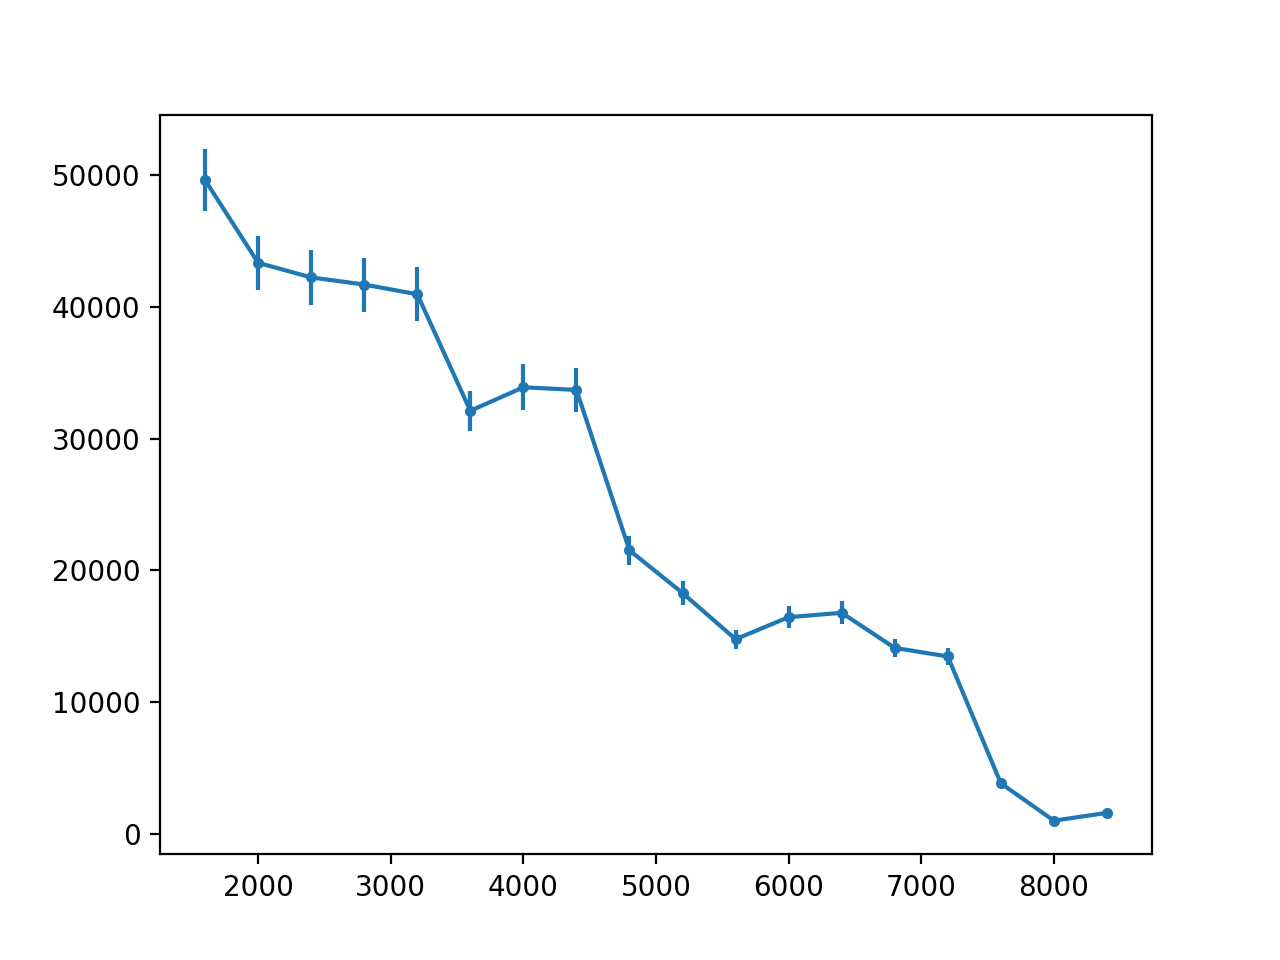

<Container object of 3 artists>

In [55]:
pred_win_size = 200
left_tail_size = 0
period = 20
start_point = 80
pred_min_delta = min_delta
report_period = 20
wtype = 'linear'
num_samples = 1000
init_d = 0
var_ud = 1e-5

# it's acually equivalent to setting no upper limit because 2e5 is larger enough
upper_limit = 2e5

# set a effective upper limit
# upper_limit_bias = 80
# upper_limit = (len(val_err) + upper_limit_bias)*num_epochs_between_eval

preds, CIs, samples, d_ests, KF = indicatorSimulation(
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     pred_min_delta,
                                     patience,
                                    report_period,
                                    pred_win_size = pred_win_size,
                                    period = period,
                                    init_d = init_d,
                                    var_ud = var_ud,
                                    start_point = start_point,
                                    num_samples=1000,
                                    upper_limit=upper_limit)
print(len(preds))

errs = CIs2errs(CIs)

plt.figure()
x = (start_point+(np.arange(len(preds)))*report_period)*num_epochs_between_eval
plt.errorbar(x, preds-x, errs, fmt='.-')

<IPython.core.display.Javascript object>


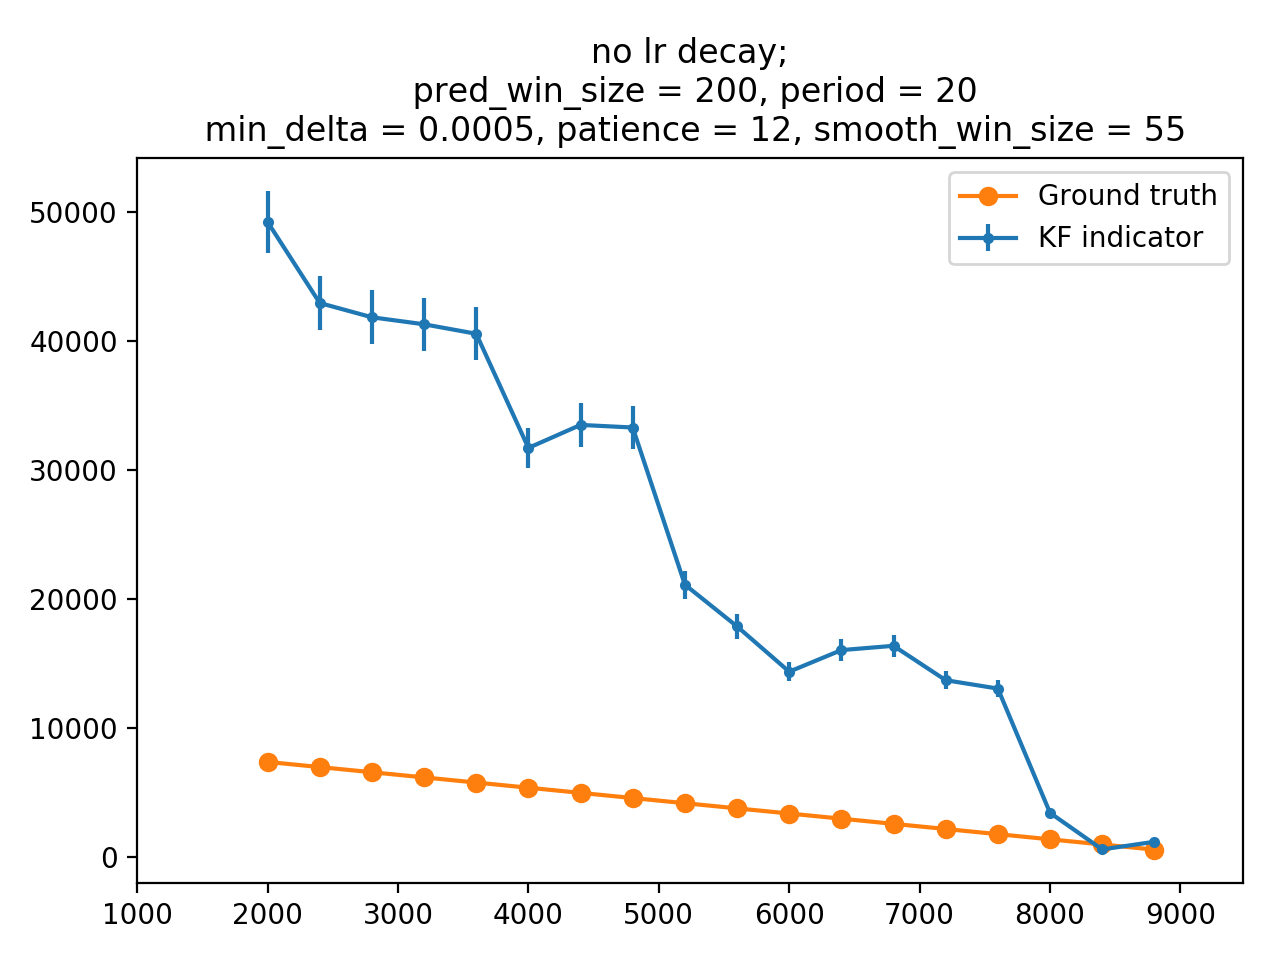

In [56]:
fig = plt.figure()

x = (start_point+period+(np.arange(len(preds)))*report_period)*num_epochs_between_eval
plt.errorbar(x, preds-x, errs, fmt='.-')
plt.plot(x, earlyStoppingStep-x,'-o')
plt.xlim(1000,earlyStoppingStep+100)
# plt.ylim(-200, 22000)
plt.legend(['Ground truth', 'KF indicator'])
plt.title('no lr decay;\n pred_win_size = {0}, period = {1}\n min_delta = {2}, patience = {3}, smooth_win_size = {4}'.
          format(pred_win_size, period, min_delta, patience, smooth_win_size))
fig.tight_layout()


plt.savefig('result_figs/power_plus_tanh/bs_128_no_lr_decay/min_delta_5e_4_patience_12/change_patience/patience_12.png')

In [57]:
KF.d_est, d_ests

(-0.006300448837936955,
 [-0.0017240484226641623,
  -0.001686789979335257,
  -0.0016377157024713524,
  -0.000991227555726718,
  -0.0010793619112243451,
  -0.0020469387289862263,
  -0.0009781252242665724,
  -0.0006139320404955873,
  -0.001188346202433624,
  0.0002548449234550875,
  0.0002851964085276469,
  0.00046290348789374594,
  0.00025909437035511677,
  0.00062891330929447,
  0.0015365569963422573,
  0.004515721051316094,
  -0.010217179599401069,
  -0.006300448837936955])

<IPython.core.display.Javascript object>


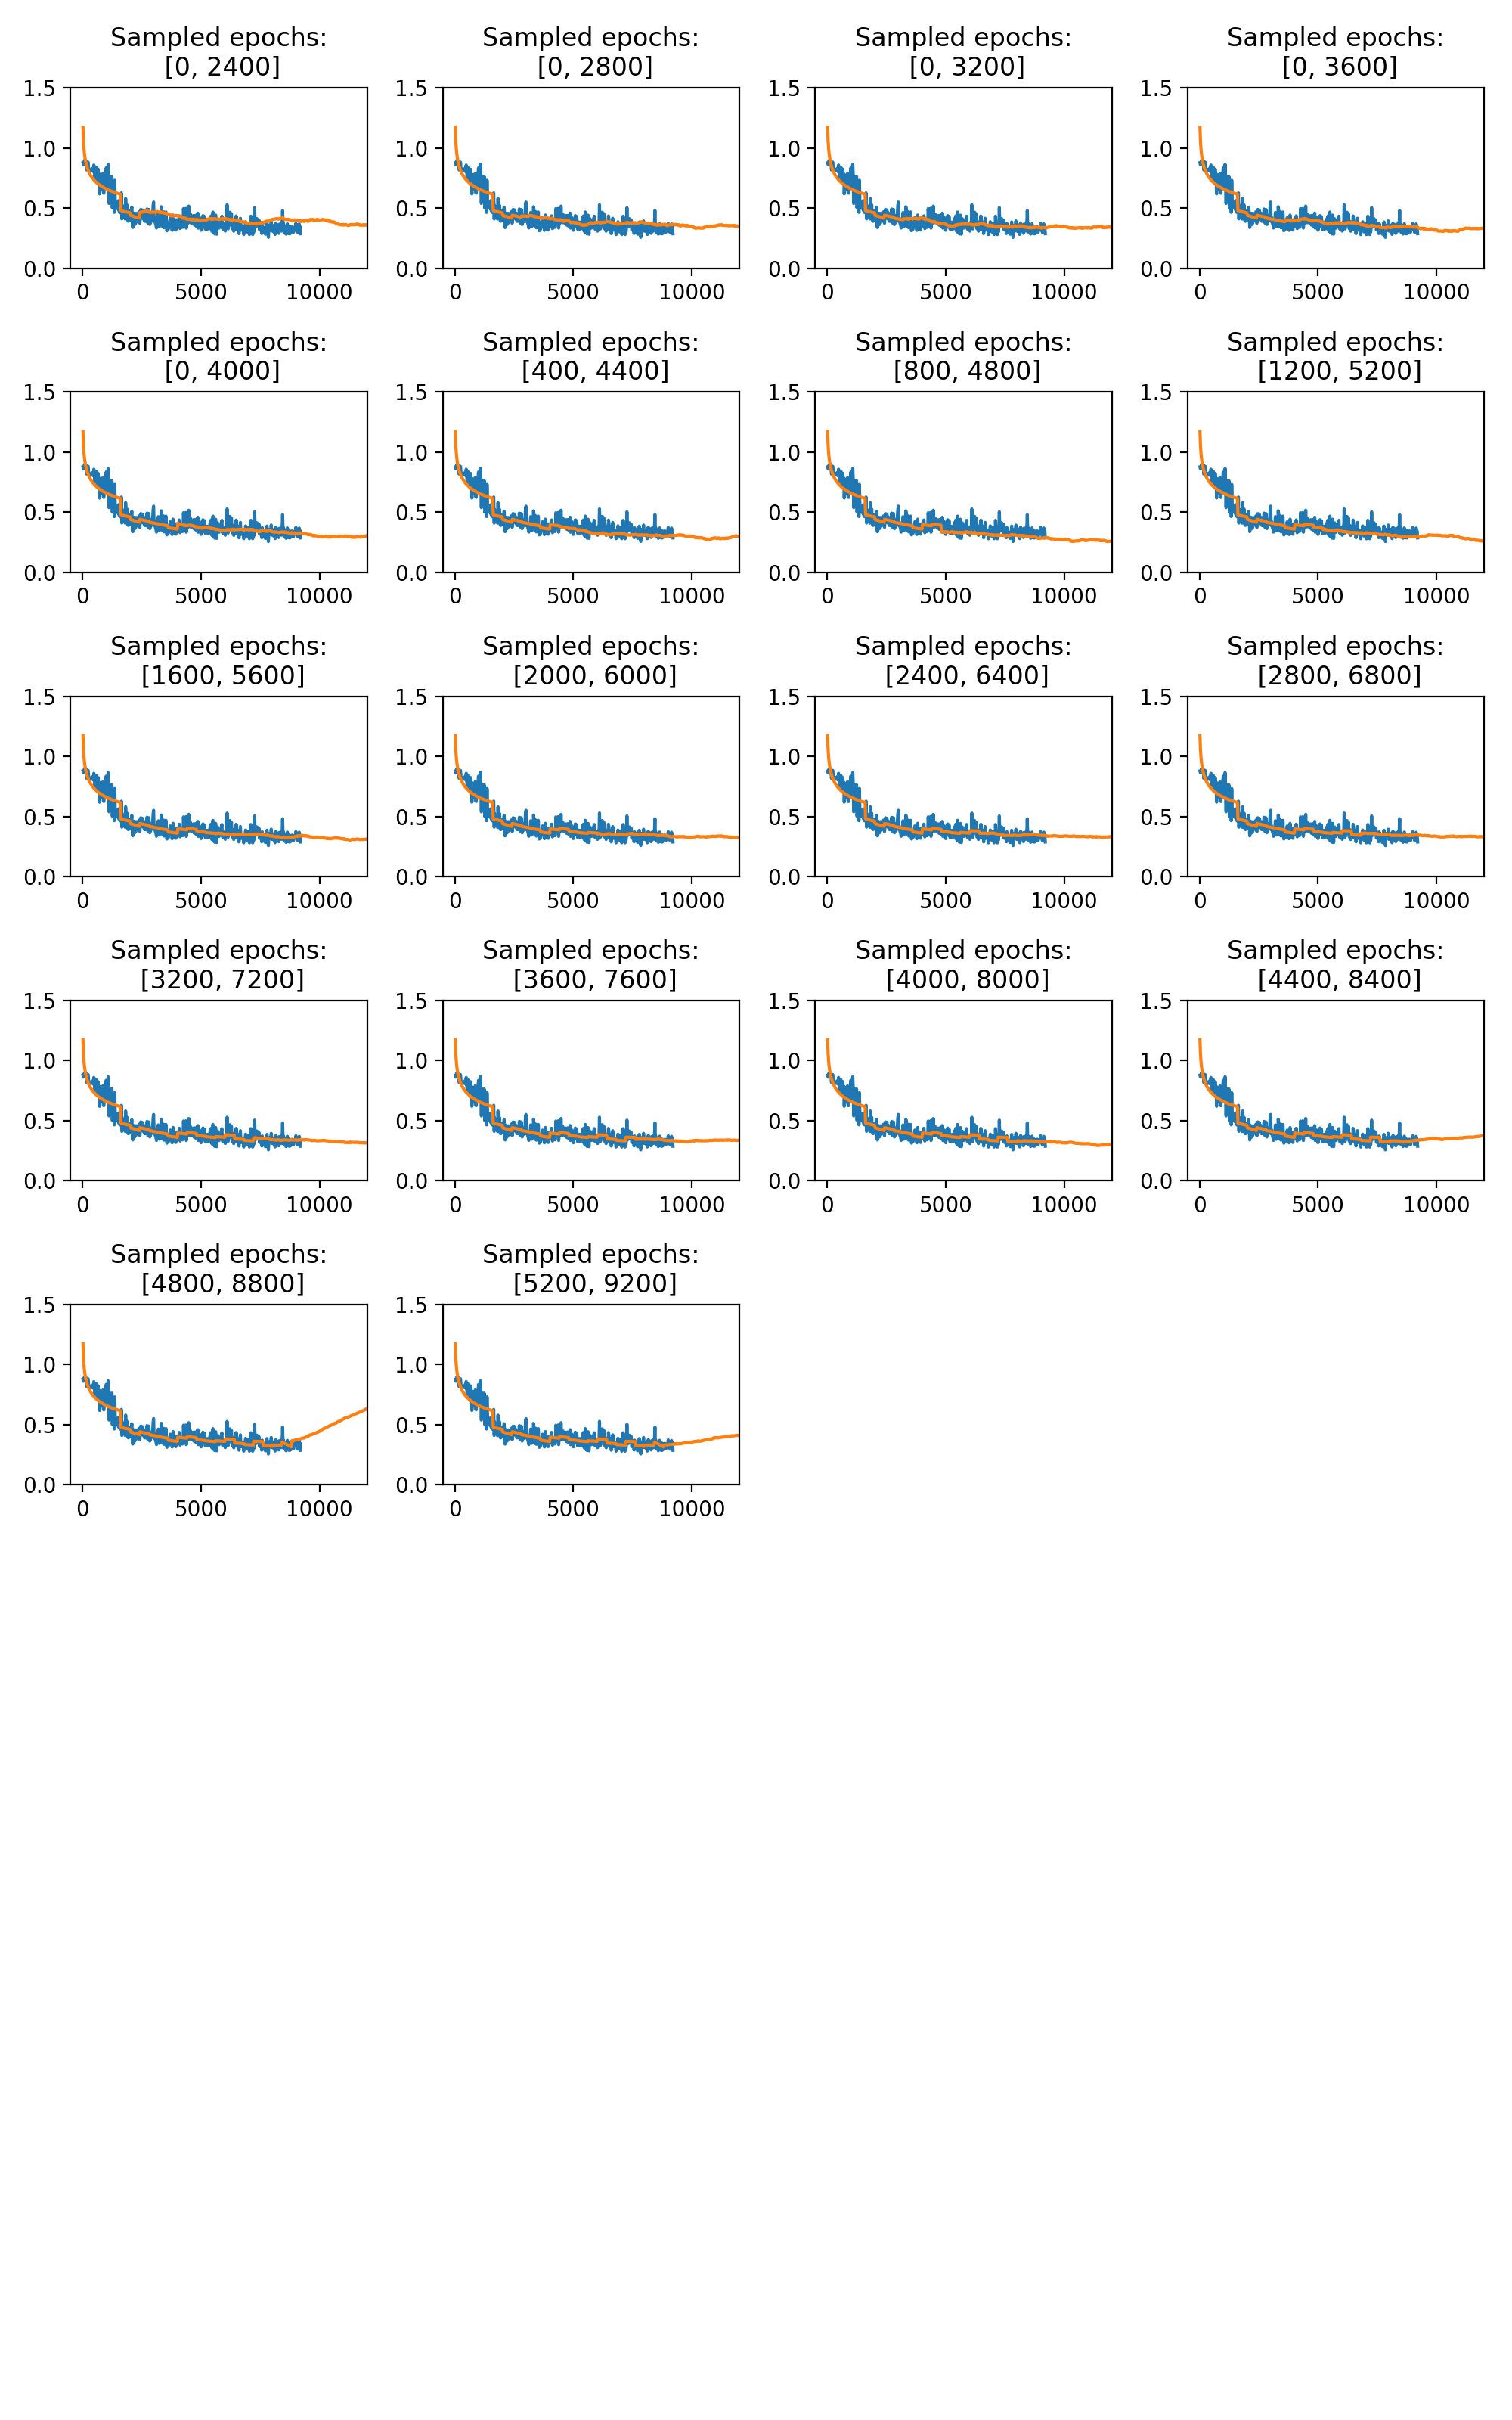

In [58]:
# print(coeffs)
fig = plt.figure(figsize=[10, 16])
# ax = plt.subplot()
# ax.set_ylim(0, 1.5)
# ax.plot(steps, val_err)

co = 0
step_size = 1
KF_steps = (np.arange(len(KF.all_original_data)) + 1) * num_epochs_between_eval
for i in range(0,len(samples),step_size):
    co += 1
    ax = plt.subplot(8,4, co)
    ax.set_ylim(0, 1.5)
#     ax.plot(steps, val_err)
    ax.plot(KF_steps, KF.all_original_data)
    x = np.arange(1,len(samples[i])+1)*num_epochs_between_eval
#     ax.plot(x,smoothed_samples[i])
    ax.plot(x,samples[i])
#     ax.plot(steps+shifts[i], coeffs[i][0]*np.power(steps,coeffs[i][1]))
    e = (start_point + (i+1)*report_period + period)*num_epochs_between_eval
    s = max(0, ((start_point+(i+1)*report_period + period) - pred_win_size)*num_epochs_between_eval)
    ax.set_title('Sampled epochs:\n [{}, {}]'.format(s,e))
    ax.set_xlim(-500,12000)
    
fig.tight_layout()   

<IPython.core.display.Javascript object>


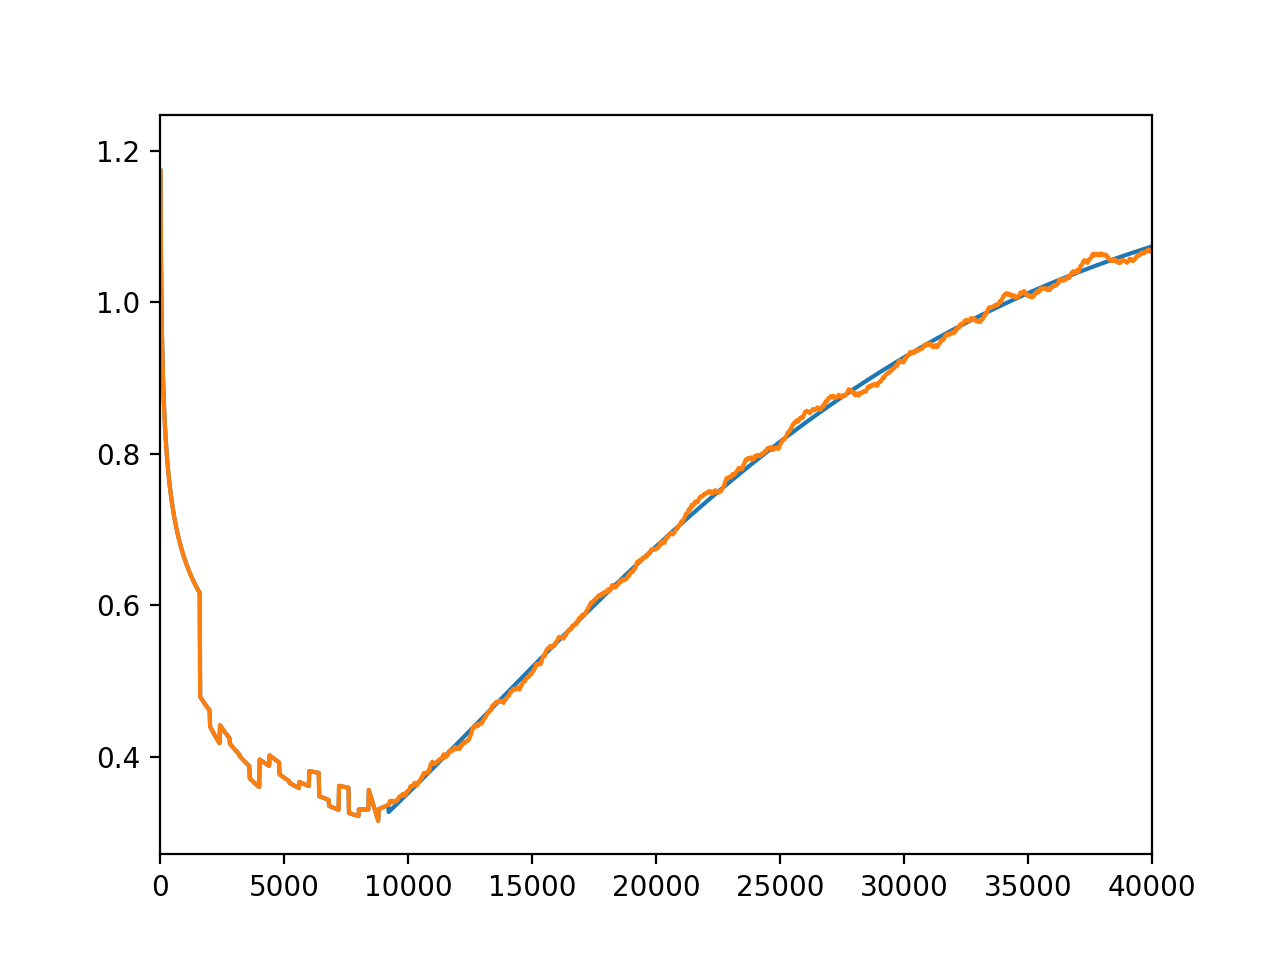

(2.6637135663509928,
 -0.22990498393912118,
 -0.006300448837936955,
 1.1593208911402861,
 0.999999745388592,
 0.15932114575169404)

In [59]:
num = int(upper_limit//num_epochs_between_eval)
s_queue = list(KF.s_est)
epoch_queue = list(KF.epochs)
predicts = []
a, b = power_regression(np.array(epoch_queue), np.array(s_queue), np.ones(len(s_queue)))
for i in range(1,num):
            
#             if (i-1) % KF.pointPeriod == 0:
#                 a, b = power_regression(np.array(epoch_queue), np.array(s_queue), np.ones(len(s_queue)))
#                 print(a,b)
            if i == 1:
                store_a = a
                store_b = b
            epoch = KF.epochs[-1] + i * KF.numEpsBtwVal
            if len(epoch_queue) >= KF.predWinSize:
                epoch_queue.pop(0)
            epoch_queue.append(epoch)
#             print(epoch_queue)

            predict = power_function(epoch, a, b) + np.tanh(np.power(KF.d_est,2)*(epoch-KF.epochs[-1]))
            predicts.append(predict)
            if len(s_queue) >= KF.predWinSize:
                s_queue.pop(0)
            s_queue.append(predict)

# print(predicts)

fig = plt.figure()
all_points = np.concatenate([KF.all_estimates,predicts])
steps0 = (np.arange(len(all_points))+1)*num_epochs_between_eval
steps1 = (np.arange(len(all_points)+50)+1)*num_epochs_between_eval
plt.plot(steps0, all_points)
plt.plot(steps0[:len(samples[-1])], samples[-1])
# plt.plot(steps1, power_function(steps1, KF.c_est, KF.d_est) + power_function(steps1, store_a, store_b))
plt.xlim(0, 40000)
# plt.ylim(0,1)

a,b, KF.d_est, predict, np.tanh(np.power(d_ests[-1],2)*(epoch-KF.epochs[-1])), power_function(epoch, a, b)